<a href="https://colab.research.google.com/github/pAbhit007/Machine-Learning-Models-Code/blob/main/GANs_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Define a basic transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
train_dataset = datasets.CIFAR10(root='./data',\
              train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(train_dataset, \
                                batch_size=32, shuffle=True)

100%|██████████| 170498071/170498071 [00:12<00:00, 13549003.77it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


DISPLAYING ORIGINAL DATASETS

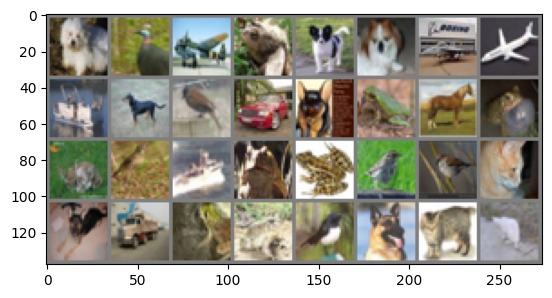

In [13]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(dataloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))


In [11]:
# Print labels
print(' '.join('%5s' % train_dataset.classes[labels[j]] for j in range(32)))

 ship  bird  bird  frog   cat  ship  bird automobile horse  bird   cat   cat   dog horse  bird  ship   dog airplane   cat  bird airplane   cat   dog  bird  deer   cat   dog   dog   cat  frog horse  deer


In [4]:
# Hyperparameters
latent_dim = 100
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
num_epochs = 10

# Generator

In [5]:
# Define the generator
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img

# Discriminator

In [6]:
# Define the discriminator
class Discriminator(nn.Module):
	def __init__(self):
		super(Discriminator, self).__init__()

		self.model = nn.Sequential(
		nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
		nn.LeakyReLU(0.2),
		nn.Dropout(0.25),
		nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
		nn.ZeroPad2d((0, 1, 0, 1)),
		nn.BatchNorm2d(64, momentum=0.82),
		nn.LeakyReLU(0.25),
		nn.Dropout(0.25),
		nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
		nn.BatchNorm2d(128, momentum=0.82),
		nn.LeakyReLU(0.2),
		nn.Dropout(0.25),
		nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
		nn.BatchNorm2d(256, momentum=0.8),
		nn.LeakyReLU(0.25),
		nn.Dropout(0.25),
		nn.Flatten(),
		nn.Linear(256 * 5 * 5, 1),
		nn.Sigmoid()
	)

	def forward(self, img):
		validity = self.model(img)
		return validity


# Intializing GAN Model

In [7]:
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
# Loss function
adversarial_loss = nn.BCELoss()
# Optimizers
optimizer_G = optim.Adam(generator.parameters()\
                         , lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters()\
                         , lr=lr, betas=(beta1, beta2))

# Training

Epoch [1/10]                        Batch 100/1563 Discriminator Loss: 0.6355 Generator Loss: 1.3126
Epoch [1/10]                        Batch 200/1563 Discriminator Loss: 0.4831 Generator Loss: 1.6008
Epoch [1/10]                        Batch 300/1563 Discriminator Loss: 0.6069 Generator Loss: 0.8977
Epoch [1/10]                        Batch 400/1563 Discriminator Loss: 0.5422 Generator Loss: 1.5190
Epoch [1/10]                        Batch 500/1563 Discriminator Loss: 0.6581 Generator Loss: 1.2156
Epoch [1/10]                        Batch 600/1563 Discriminator Loss: 0.6765 Generator Loss: 0.8246
Epoch [1/10]                        Batch 700/1563 Discriminator Loss: 0.9269 Generator Loss: 0.7695
Epoch [1/10]                        Batch 800/1563 Discriminator Loss: 0.6357 Generator Loss: 0.9478
Epoch [1/10]                        Batch 900/1563 Discriminator Loss: 0.5985 Generator Loss: 1.0405
Epoch [1/10]                        Batch 1000/1563 Discriminator Loss: 0.6339 Generator Lo

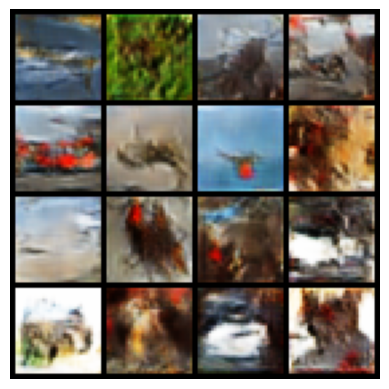

In [8]:
# Training loop
for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader):
        real_images = batch[0].to(device)
        valid = torch.ones(real_images.size(0), 1, device=device)
        fake = torch.zeros(real_images.size(0), 1, device=device)
        real_images = real_images.to(device)

        #  Train Discriminator
        optimizer_D.zero_grad()
        z = torch.randn(real_images.size(0), latent_dim, device=device)
        fake_images = generator(z)

        real_loss = adversarial_loss(discriminator\
                                     (real_images), valid)
        fake_loss = adversarial_loss(discriminator\
                                     (fake_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        #  Train Generator
        optimizer_G.zero_grad()
        gen_images = generator(z)
        g_loss = adversarial_loss(discriminator(gen_images), valid)
        g_loss.backward()
        optimizer_G.step()

        if (i + 1) % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}]\
                        Batch {i+1}/{len(dataloader)} "
                f"Discriminator Loss: {d_loss.item():.4f} "
                f"Generator Loss: {g_loss.item():.4f}"
            )
    # Save generated images for every epoch
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            z = torch.randn(16, latent_dim, device=device)
            generated = generator(z).detach().cpu()
            grid = torchvision.utils.make_grid(generated,\
                                        nrow=4, normalize=True)
            plt.imshow(np.transpose(grid, (1, 2, 0)))
            plt.axis("off")
            plt.show()

### If we increase the epochs it will also increase more defined images